<a href="https://colab.research.google.com/github/eirenengoc/ufc/blob/main/NgocTa_Project_UFC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATASET - UFC: Fighters And Matches

# A - DATA PREPARATION

In [ ]:
#IMPORT FILES
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

url = 'https://drive.google.com/file/d/1BEsr5ntkueNKAEE0CQ0VzVlf_GlW8hJT/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
matches = pd.read_csv(path)

# CLEAN DATA:
# Split matches by fighter groups & combine them into 1 Fighter List
df_R = matches.filter(regex='(^R_|weight_class)')
df_B = matches.filter(regex='(^B_|weight_class)')

df_R = df_R.rename(columns=lambda x: re.sub('R_','',x))
df_B = df_B.rename(columns=lambda x: re.sub('B_','',x))
df_fighter = pd.concat([df_R,df_B], axis=0, ignore_index=True)

# EVALUATE & RANK FIGHTERS BASED ON THEIR PAST PERFORMANCE:
# Create total_bouts column (total fights each fighters participated in):
df_1 = df_fighter.filter(regex='^[^(avg_)]|age')
total_fought = df_fighter['fighter'].value_counts().to_dict()

def get_bouts(x):
    return total_fought[x]

df_1.insert(2,'total_bouts',df_1['fighter'].apply(get_bouts))

# Reindex columns & group by Fighters:
df_1.insert(3, 'wins', df_1.pop('wins'))
df_1.insert(4, 'draw', df_1.pop('draw'))
df_1.insert(5, 'losses', df_1.pop('losses'))
df_1 = df_1.groupby('fighter').max().reset_index()

# Create coefficient value to rank fighters (Good - Average - Bad)
df_1.insert(6, 'coefficient', (df_1['wins'] - df_1['losses'])/df_1['total_bouts'])
df_1.insert(7, 'rank', df_1['coefficient'].transform(lambda x: pd.qcut(x.rank(method='first'), q = 3, labels = ['Bad','Average','Good'])))
df_1.sample(5)

,fighter,weight_class,total_bouts,wins,draw,losses,coefficient,rank,current_lose_streak,current_win_streak,...,win_by_Decision_Split,win_by_Decision_Unanimous,win_by_KO/TKO,win_by_Submission,win_by_TKO_Doctor_Stoppage,Stance,Height_cms,Reach_cms,Weight_lbs,age
455,David Hood,Open Weight,1,0.0,0.0,0.0,0.00,Average,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,182.88,NaN,200.0,NaN
744,Jacob Volkmann,Welterweight,10,6.0,0.0,3.0,0.30,Good,2.0,5.0,...,2.0,3.0,0.0,1.0,0.0,Southpaw,175.26,180.34,155.0,32.0
1366,Nick Pace,Bantamweight,3,1.0,0.0,1.0,0.00,Average,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,Orthodox,170.18,172.72,135.0,24.0
1062,Kevin Souza,Featherweight,4,3.0,0.0,0.0,0.75,Good,0.0,3.0,...,1.0,0.0,2.0,0.0,0.0,Orthodox,182.88,187.96,145.0,31.0
1506,Richard Crunkilton,Lightweight,1,0.0,0.0,0.0,0.00,Average,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Orthodox,170.18,NaN,155.0,23.0


Text(0.5, 1.0, "WINNER LIST'S CORRELATION")

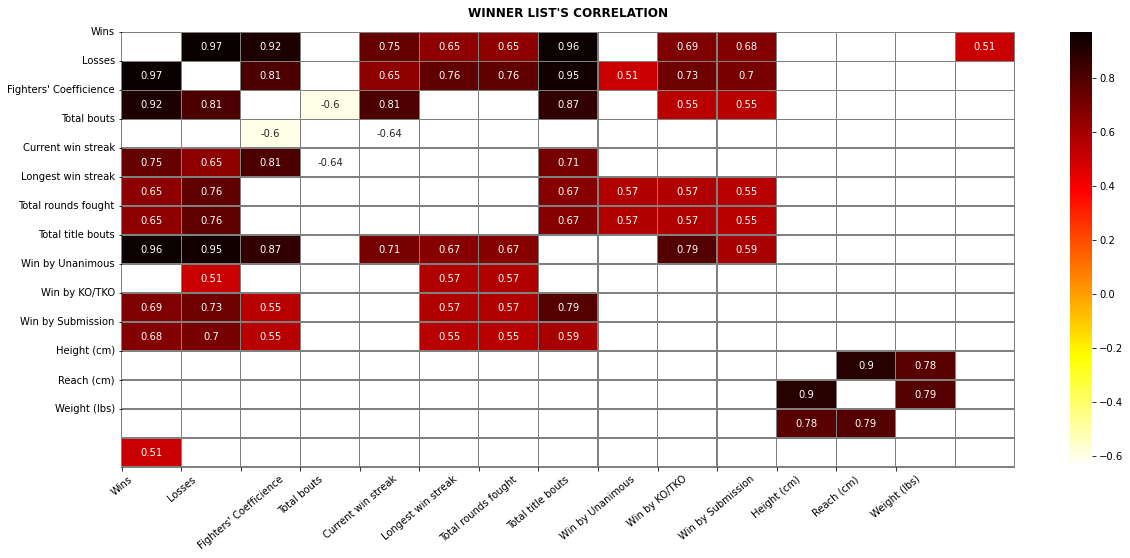

In [ ]:
#FILTER OUT GOOD FIGHTERS GROUP TO ANALYZE:
#Get Overview Winner List, Female & Male Winner list:
winner_list = df_1[df_1['rank'].str.contains('Good',na = False)]
winner_list['weight_class'].str.strip()
f_winners = df_1.loc[(df_1['rank'] == 'Good') & df_1['weight_class'].str.contains('Women')]
m_winners = df_1.loc[(df_1['rank'] == 'Good') & (df_1['weight_class'].str.contains("Women") == False)]

#Filter out strong correlations in Winner List:
winner_corr = winner_list.corr().round(2)
winner_corr = winner_corr[(abs(winner_corr) >= 0.5) & (abs(winner_corr) < 1)]
winner_corr = winner_corr.dropna(how = 'all')
winner_corr = winner_corr.dropna(how = 'all', axis = 1)

#Visualize values with high correlation using Correlation Heatmap:
plt.figure(figsize = (20,8))
sns.heatmap(winner_corr, linewidths=0.1, linecolor='grey', annot=True, cmap  = 'hot_r', fmt='g', clip_on=False)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13], ['Wins', 'Losses', "Fighters' Coefficience",'Total bouts', 'Current win streak', 'Longest win streak', 'Total rounds fought', 'Total title bouts', 'Win by Unanimous', 'Win by KO/TKO', 'Win by Submission', 'Height (cm)', 'Reach (cm)', 'Weight (lbs)'], rotation=40, ha='center')
plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13], ['Wins', 'Losses', "Fighters' Coefficience",'Total bouts', 'Current win streak', 'Longest win streak', 'Total rounds fought', 'Total title bouts', 'Win by Unanimous', 'Win by KO/TKO', 'Win by Submission', 'Height (cm)', 'Reach (cm)', 'Weight (lbs)'])
plt.title("WINNER LIST'S CORRELATION", weight='bold', pad=15)

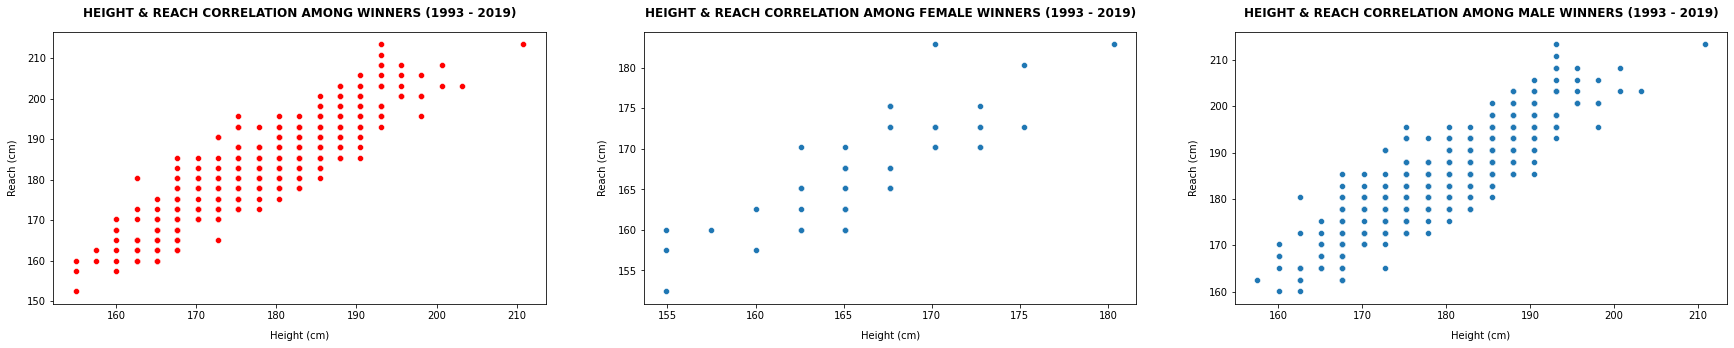

In [ ]:
#Q1 - FIND CORRELATION BETWEEN HEIGHT & REACH:
#Plot data by Winner List, Female & Male Winner List
plt.figure(figsize = (30,5))

plt.subplot(131)
sns.scatterplot(data=winner_list, x='Height_cms', y = 'Reach_cms', color ='Red')
plt.title("HEIGHT & REACH CORRELATION AMONG WINNERS (1993 - 2019)", weight='bold', pad=15)
plt.xlabel('Height (cm)', labelpad=10)
plt.ylabel('Reach (cm)', labelpad=10)

plt.subplot(132)
sns.scatterplot(data=f_winners, x='Height_cms', y = 'Reach_cms')
plt.title("HEIGHT & REACH CORRELATION AMONG FEMALE WINNERS (1993 - 2019)", weight='bold', pad=15)
plt.xlabel('Height (cm)', labelpad=10)
plt.ylabel('Reach (cm)', labelpad=10)

plt.subplot(133)
sns.scatterplot(data=m_winners, x='Height_cms', y = 'Reach_cms')
plt.title("HEIGHT & REACH CORRELATION AMONG MALE WINNERS (1993 - 2019)", weight='bold', pad=15)
plt.xlabel('Height (cm)', labelpad=10)
plt.ylabel('Reach (cm)', labelpad=10)
plt.show()

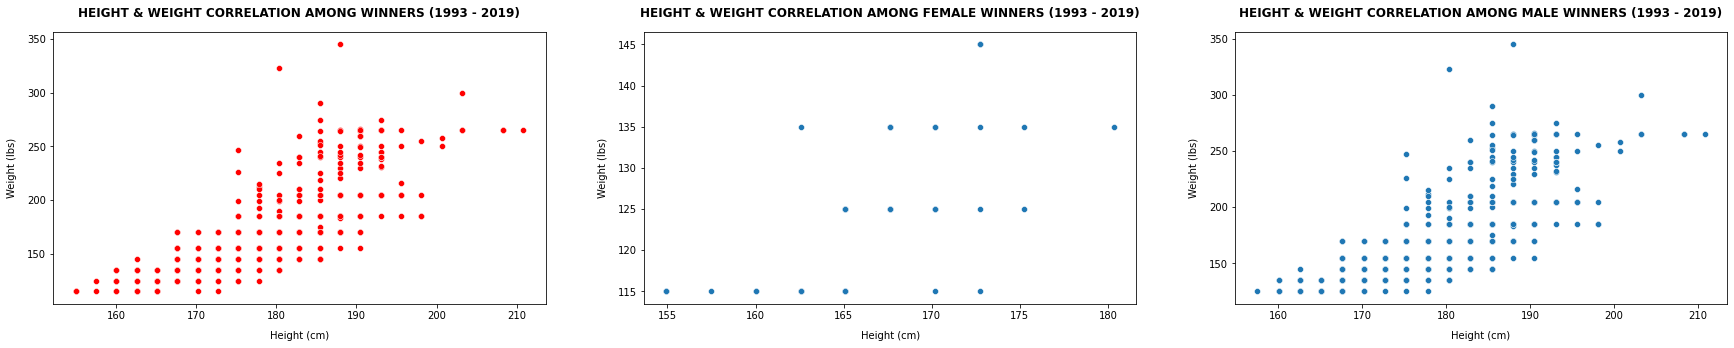

In [ ]:
#Q1 - FIND CORRELATION BETWEEN HEIGHT & WEIGHT:
#Plot data by Winner List, Female & Male Winner List
plt.figure(figsize = (30,5))

plt.subplot(131)
sns.scatterplot(data=winner_list, x='Height_cms', y = 'Weight_lbs', color ='Red')
plt.title("HEIGHT & WEIGHT CORRELATION AMONG WINNERS (1993 - 2019)", weight='bold', pad=15)
plt.xlabel('Height (cm)', labelpad=10)
plt.ylabel('Weight (lbs)', labelpad=10)

plt.subplot(132)
sns.scatterplot(data=f_winners, x='Height_cms', y = 'Weight_lbs')
plt.title("HEIGHT & WEIGHT CORRELATION AMONG FEMALE WINNERS (1993 - 2019)", weight='bold', pad=15)
plt.xlabel('Height (cm)', labelpad=10)
plt.ylabel('Weight (lbs)', labelpad=10)

plt.subplot(133)
sns.scatterplot(data=m_winners, x='Height_cms', y = 'Weight_lbs')
plt.title("HEIGHT & WEIGHT CORRELATION AMONG MALE WINNERS (1993 - 2019)", weight='bold', pad=15)
plt.xlabel('Height (cm)', labelpad=10)
plt.ylabel('Weight (lbs)', labelpad=10)
plt.show()

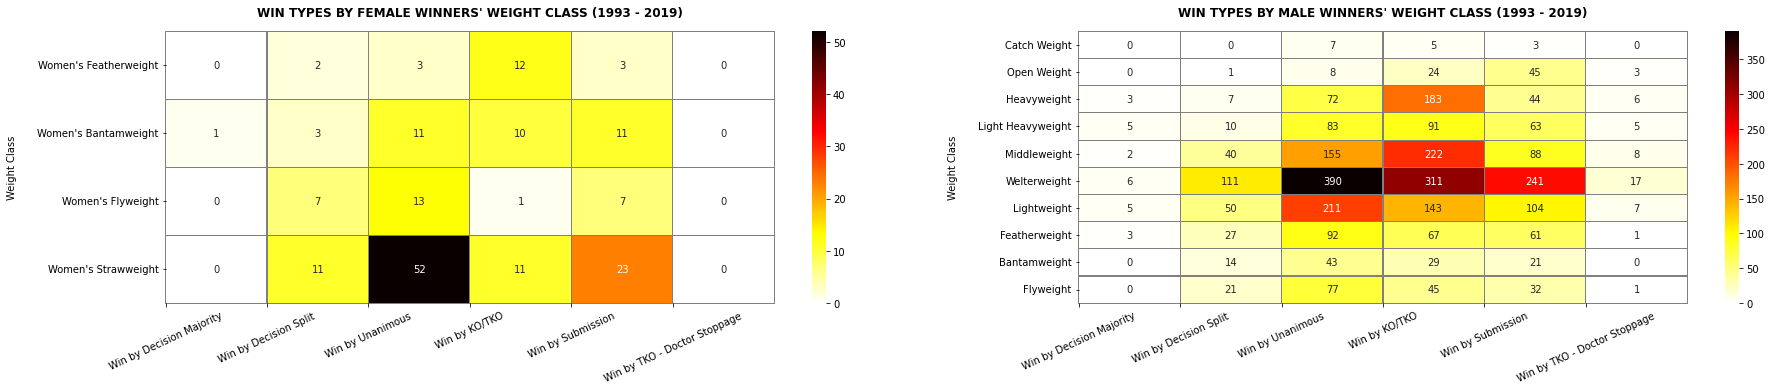

In [ ]:
#Q1 - FIND MOST COMMON TYPES OF WIN:
#Filter out Female winners' win types by their weight class (sorted Heavy - Light):
f_win_by = f_winners.groupby(['weight_class']).agg({'win_by_Decision_Majority':'sum', 'win_by_Decision_Split':'sum','win_by_Decision_Unanimous':'sum', 'win_by_KO/TKO':'sum', 
                                              'win_by_Submission':'sum','win_by_TKO_Doctor_Stoppage':'sum'}).astype(int)

sorted_f = ["Women's Featherweight","Women's Bantamweight", "Women's Flyweight","Women's Strawweight"]
f_win_by = f_win_by.loc[sorted_f]

#Filter out Male winners' win types by their weight class (sorted Heavy - Light):
m_win_by = m_winners.groupby(['weight_class']).agg({'win_by_Decision_Majority':'sum', 'win_by_Decision_Split':'sum','win_by_Decision_Unanimous':'sum', 'win_by_KO/TKO':'sum', 
                                              'win_by_Submission':'sum','win_by_TKO_Doctor_Stoppage':'sum'}).astype(int)

sorted_m = ['Catch Weight','Open Weight','Heavyweight','Light Heavyweight','Middleweight','Welterweight','Lightweight', 'Featherweight','Bantamweight','Flyweight']
m_win_by = m_win_by.loc[sorted_m]

#Plot data:
plt.figure(figsize = (30,5))

plt.subplot(121)
sns.heatmap(f_win_by, linewidths=0.1, linecolor='grey', annot=True, cmap  = 'hot_r', fmt='g', clip_on=False)
plt.title("WIN TYPES BY FEMALE WINNERS' WEIGHT CLASS (1993 - 2019)", weight='bold', pad=15)
plt.xticks([0,1,2,3,4,5], ['Win by Decision Majority', 'Win by Decision Split', 'Win by Unanimous', 'Win by KO/TKO', 'Win by Submission', 'Win by TKO - Doctor Stoppage'], rotation=25, ha='center')
plt.ylabel('Weight Class', labelpad=20)

plt.subplot(122)
sns.heatmap(m_win_by, linewidths=0.1, linecolor='grey', annot=True, cmap  = 'hot_r', fmt='g', clip_on=False)
plt.title("WIN TYPES BY MALE WINNERS' WEIGHT CLASS (1993 - 2019)", weight='bold', pad=15)
plt.xticks([0,1,2,3,4,5], ['Win by Decision Majority', 'Win by Decision Split', 'Win by Unanimous', 'Win by KO/TKO', 'Win by Submission', 'Win by TKO - Doctor Stoppage'], rotation=25, ha='center')
plt.ylabel('Weight Class', labelpad=20)
plt.show()

<Figure size 720x360 with 0 Axes>

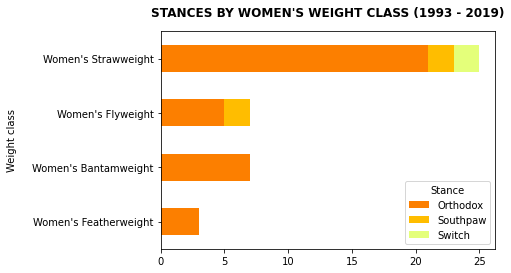

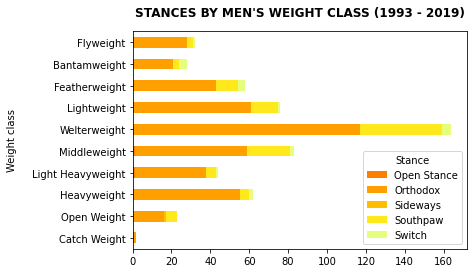

In [ ]:
#Q2 - FIND MOST COMMON STANCE:
#Stance types by Female Winners (sorted Heavy - Light):
f_stance = f_winners.groupby(['weight_class']).agg({'Stance':'value_counts'}).astype(int)
f_stance.rename(columns = {'Stance':'stance_count'}, inplace = True)

f_stance = pd.pivot_table(
                  data = f_stance,
                  index = 'weight_class',
                  columns = ['Stance'],
                  values = 'stance_count').fillna(0)

f_stance = f_stance.loc[sorted_f].reset_index()

#Stance types by Male Winners (sorted Heavy - Light):
m_stance = m_winners.groupby(['weight_class']).agg({'Stance':'value_counts'}).astype(int)
m_stance.rename(columns = {'Stance':'stance_count'}, inplace = True)

m_stance = pd.pivot_table(
                  data = m_stance,
                  index = 'weight_class',
                  columns = ['Stance'],
                  values = 'stance_count').fillna(0)

# m_stance.reset_index().set_index('weight_class', inplace = True)
m_stance = m_stance.loc[sorted_m].reset_index()

#Plot data:
plt.figure(figsize = (10,5))

# plt.subplot(121) 
f_stance.plot(kind='barh', x ='weight_class', stacked=True, cmap = 'Wistia_r')
plt.title("STANCES BY WOMEN'S WEIGHT CLASS (1993 - 2019)", weight='bold', pad=15)
plt.ylabel('Weight class', labelpad=15)
plt.show()

print("\n")

# plt.subplot(122)
m_stance.plot(kind='barh', x ='weight_class', stacked=True, cmap = 'Wistia_r')
plt.title("STANCES BY MEN'S WEIGHT CLASS (1993 - 2019)", weight='bold', pad=15)
plt.ylabel('Weight class', labelpad=15)
plt.show()

In [ ]:
#Q2 - EVALUATE FIGHT TACTICS
#Get Attack table by fighters' Name
fighter_name = df_fighter['fighter']
att_tmp = df_fighter.filter(regex='(^avg_[A-Z].*att$)')
att_table = pd.concat([fighter_name,att_tmp], axis=1).groupby(['fighter']).mean()

#Get Landed table
landed_tmp = df_fighter.filter(regex='(^avg_[A-Z].*landed$)')
landed_table = pd.concat([fighter_name,landed_tmp], axis=1).groupby(['fighter']).mean()

#Get Female & Male Winners' Attack table
f_winners_tmp = f_winners['fighter']
m_winners_tmp = m_winners['fighter']

f_winners_att = pd.merge(f_winners_tmp, att_table,  how='left', left_on='fighter', right_on = 'fighter').round(2)
m_winners_att = pd.merge(m_winners_tmp, att_table,  how='left', left_on='fighter', right_on = 'fighter').round(2)

#Get Female Winners' Landed table
f_winners_landed = pd.merge(f_winners_tmp, landed_table,  how='left', left_on='fighter', right_on = 'fighter').round(2)
m_winners_landed = pd.merge(m_winners_tmp, landed_table,  how='left', left_on='fighter', right_on = 'fighter').round(2)

m_winners_att.head()

,fighter,avg_BODY_att,avg_CLINCH_att,avg_DISTANCE_att,avg_GROUND_att,avg_HEAD_att,avg_LEG_att,avg_SIG_STatt,avg_TD_att,avg_TOTAL_STatt,avg_SIG_STR_att,avg_TOTAL_STR_att
0,Aaron Simpson,9.85,17.06,34.09,15.54,50.01,6.83,64.72,6.40,93.13,71.29,97.61
1,Abdul Razak Alhassan,1.71,5.42,41.73,2.08,45.12,2.40,37.88,0.44,40.50,60.58,63.33
2,Abel Trujillo,12.50,15.39,36.56,14.37,50.72,3.10,64.22,2.04,77.06,67.72,87.74
3,Adam Wieczorek,13.50,8.50,63.25,6.25,59.00,5.50,61.00,0.75,78.50,95.00,129.00
4,Adlan Amagov,9.00,16.00,77.00,6.00,53.00,37.00,NaN,10.00,NaN,99.00,118.00


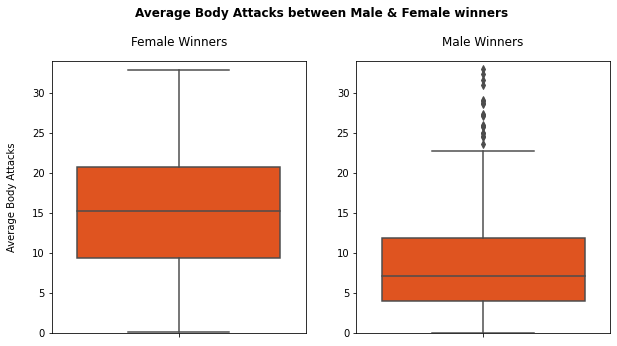

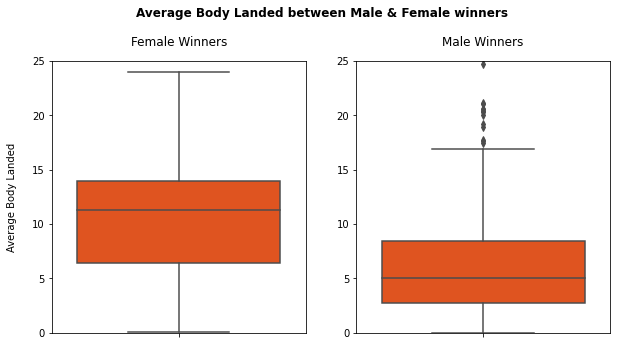

In [ ]:
#Compare Average Body Attack/Landed
plt.figure(figsize = (10,5))
ax1 = plt.subplot(121)
sns.boxplot(data=f_winners_att, y= 'avg_BODY_att', color = 'orangered')
ax1.set_ylim([0, 34])
plt.ylabel('Average Body Attacks', labelpad=15)
plt.title("Female Winners", pad=15)

ax2 = plt.subplot(122)
sns.boxplot(data=m_winners_att, y= 'avg_BODY_att', color = 'orangered')
plt.title("Male Winners", pad=15)
ax2.set_ylim([0, 34])
plt.ylabel("")
plt.suptitle('Average Body Attacks between Male & Female winners', weight='bold', y= 1.03)
plt.show()

print("\n")

plt.figure(figsize = (10,5))
ax3 = plt.subplot(121)
sns.boxplot(data=f_winners_landed, y= 'avg_BODY_landed', color = 'orangered')
ax3.set_ylim([0, 25])
plt.ylabel('Average Body Landed', labelpad=15)
plt.title("Female Winners", pad=15)

ax4 = plt.subplot(122)
sns.boxplot(data=m_winners_landed, y= 'avg_BODY_landed', color = 'orangered')
plt.title("Male Winners", pad=15)
ax4.set_ylim([0, 25])
plt.ylabel("")
plt.suptitle('Average Body Landed between Male & Female winners', weight='bold', y= 1.03)
plt.show()


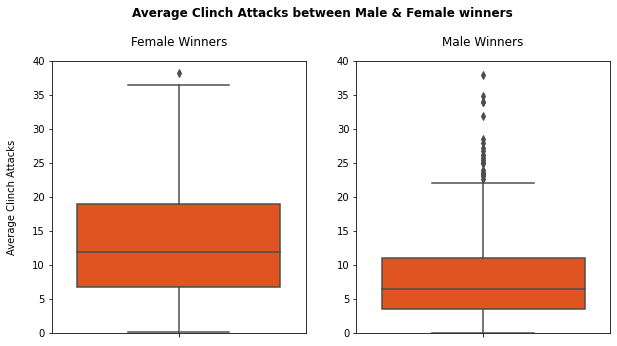

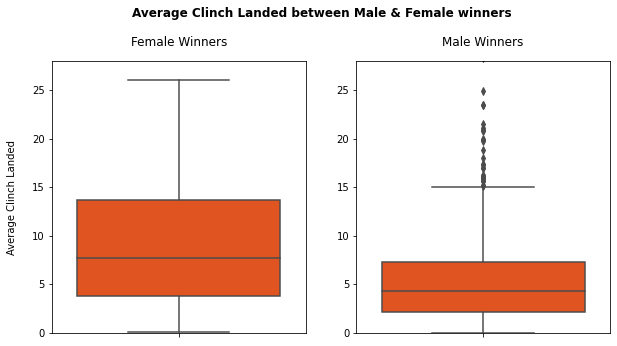

In [ ]:
#Compare Average Clinch Attack/Landed
plt.figure(figsize = (10,5))
ax1 = plt.subplot(121)
sns.boxplot(data=f_winners_att, y= 'avg_CLINCH_att', color = 'orangered')
ax1.set_ylim([0, 40])
plt.ylabel('Average Clinch Attacks', labelpad=15)
plt.title("Female Winners", pad=15)

ax2 = plt.subplot(122)
sns.boxplot(data=m_winners_att, y= 'avg_CLINCH_att', color = 'orangered')
plt.title("Male Winners", pad=15)
ax2.set_ylim([0, 40])
plt.ylabel("")
plt.suptitle('Average Clinch Attacks between Male & Female winners', weight='bold', y= 1.03)
plt.show()

print("\n")

plt.figure(figsize = (10,5))
ax3 = plt.subplot(121)
sns.boxplot(data=f_winners_landed, y= 'avg_CLINCH_landed', color = 'orangered')
ax3.set_ylim([0, 28])
plt.ylabel('Average Clinch Landed', labelpad=15)
plt.title("Female Winners", pad=15)

ax4 = plt.subplot(122)
sns.boxplot(data=m_winners_landed, y= 'avg_CLINCH_landed', color = 'orangered')
plt.title("Male Winners", pad=15)
ax4.set_ylim([0, 28])
plt.ylabel("")
plt.suptitle('Average Clinch Landed between Male & Female winners', weight='bold', y= 1.03)
plt.show()

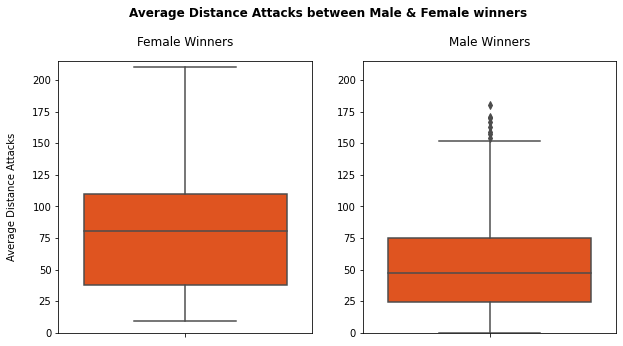

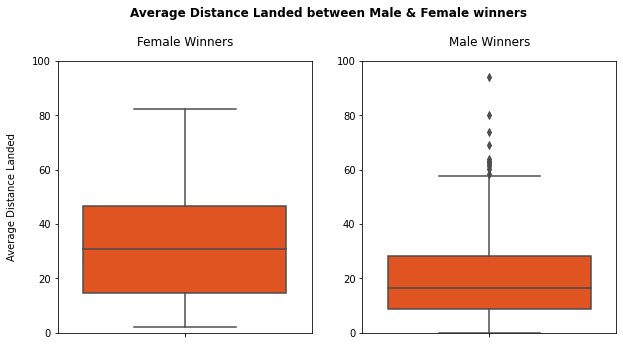

In [ ]:
#Compare Average Distance Attack/Landed
plt.figure(figsize = (10,5))
ax1 = plt.subplot(121)
sns.boxplot(data=f_winners_att, y= 'avg_DISTANCE_att', color = 'orangered')
ax1.set_ylim([0, 215])
plt.ylabel('Average Distance Attacks', labelpad=15)
plt.title("Female Winners", pad=15)

ax2 = plt.subplot(122)
sns.boxplot(data=m_winners_att, y= 'avg_DISTANCE_att', color = 'orangered')
plt.title("Male Winners", pad=15)
ax2.set_ylim([0, 215])
plt.ylabel("")
plt.suptitle('Average Distance Attacks between Male & Female winners', weight='bold', y= 1.03)
plt.show()

print("\n")

plt.figure(figsize = (10,5))
ax3 = plt.subplot(121)
sns.boxplot(data=f_winners_landed, y= 'avg_DISTANCE_landed', color = 'orangered')
ax3.set_ylim([0, 100])
plt.ylabel('Average Distance Landed', labelpad=15)
plt.title("Female Winners", pad=15)

ax4 = plt.subplot(122)
sns.boxplot(data=m_winners_landed, y= 'avg_DISTANCE_landed', color = 'orangered')
plt.title("Male Winners", pad=15)
ax4.set_ylim([0, 100])
plt.ylabel("")
plt.suptitle('Average Distance Landed between Male & Female winners', weight='bold', y= 1.03)
plt.show()

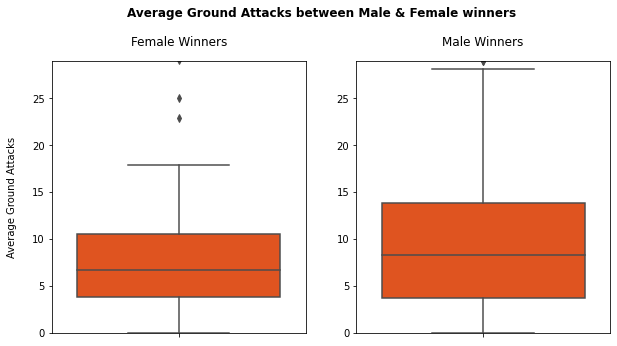

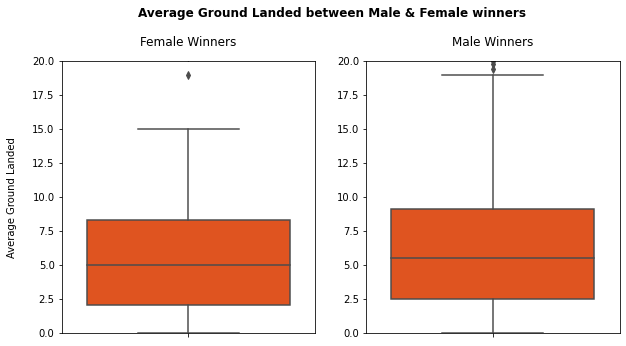

In [ ]:
#Compare Average Ground Attack/Landed
plt.figure(figsize = (10,5))
ax1 = plt.subplot(121)
sns.boxplot(data=f_winners_att, y= 'avg_GROUND_att', color = 'orangered')
ax1.set_ylim([0, 29])
plt.ylabel('Average Ground Attacks', labelpad=15)
plt.title("Female Winners", pad=15)

ax2 = plt.subplot(122)
sns.boxplot(data=m_winners_att, y= 'avg_GROUND_att', color = 'orangered')
plt.title("Male Winners", pad=15)
ax2.set_ylim([0, 29])
plt.ylabel("")
plt.suptitle('Average Ground Attacks between Male & Female winners', weight='bold', y= 1.03)
plt.show()

print("\n")

plt.figure(figsize = (10,5))
ax3 = plt.subplot(121)
sns.boxplot(data=f_winners_landed, y= 'avg_GROUND_landed', color = 'orangered')
ax3.set_ylim([0, 20])
plt.ylabel('Average Ground Landed', labelpad=15)
plt.title("Female Winners", pad=15)

ax4 = plt.subplot(122)
sns.boxplot(data=m_winners_landed, y= 'avg_GROUND_landed', color = 'orangered')
plt.title("Male Winners", pad=15)
ax4.set_ylim([0, 20])
plt.ylabel("")
plt.suptitle('Average Ground Landed between Male & Female winners', weight='bold', y= 1.03)
plt.show()

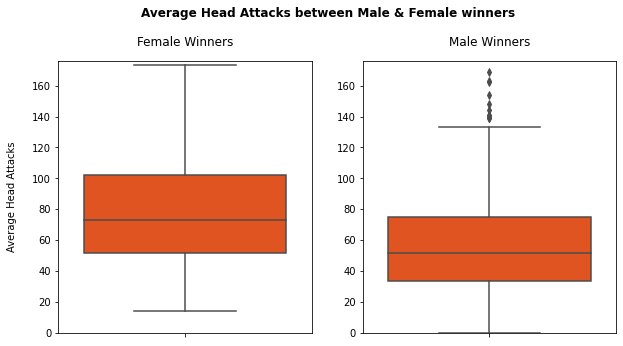

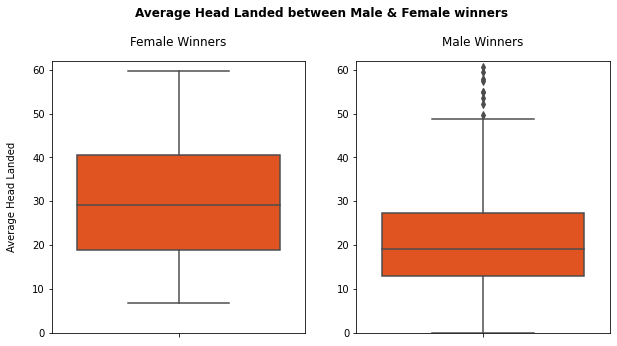

In [ ]:
#Compare Average Head Attack/Landed
plt.figure(figsize = (10,5))
ax1 = plt.subplot(121)
sns.boxplot(data=f_winners_att, y= 'avg_HEAD_att', color = 'orangered')
ax1.set_ylim([0, 176])
plt.ylabel('Average Head Attacks', labelpad=15)
plt.title("Female Winners", pad=15)

ax2 = plt.subplot(122)
sns.boxplot(data=m_winners_att, y= 'avg_HEAD_att', color = 'orangered')
plt.title("Male Winners", pad=15)
ax2.set_ylim([0, 176])
plt.ylabel("")
plt.suptitle('Average Head Attacks between Male & Female winners', weight='bold', y= 1.03)
plt.show()

print("\n")

plt.figure(figsize = (10,5))
ax3 = plt.subplot(121)
sns.boxplot(data=f_winners_landed, y= 'avg_HEAD_landed', color = 'orangered')
ax3.set_ylim([0, 62])
plt.ylabel('Average Head Landed', labelpad=15)
plt.title("Female Winners", pad=15)

ax4 = plt.subplot(122)
sns.boxplot(data=m_winners_landed, y= 'avg_HEAD_landed', color = 'orangered')
plt.title("Male Winners", pad=15)
ax4.set_ylim([0, 62])
plt.ylabel("")
plt.suptitle('Average Head Landed between Male & Female winners', weight='bold', y= 1.03)
plt.show()

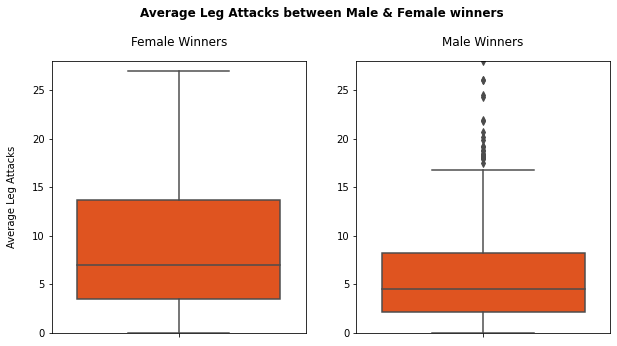

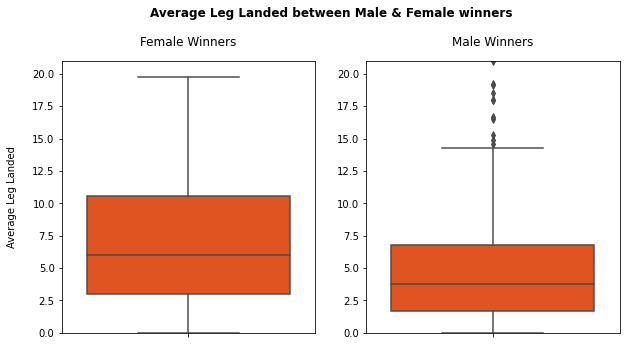

In [ ]:
#Compare Average Leg Attack/Landed
plt.figure(figsize = (10,5))
ax1 = plt.subplot(121)
sns.boxplot(data=f_winners_att, y= 'avg_LEG_att', color = 'orangered')
ax1.set_ylim([0, 28])
plt.ylabel('Average Leg Attacks', labelpad=15)
plt.title("Female Winners", pad=15)

ax2 = plt.subplot(122)
sns.boxplot(data=m_winners_att, y= 'avg_LEG_att', color = 'orangered')
plt.title("Male Winners", pad=15)
ax2.set_ylim([0, 28])
plt.ylabel("")
plt.suptitle('Average Leg Attacks between Male & Female winners', weight='bold', y= 1.03)
plt.show()

print("\n")

plt.figure(figsize = (10,5))
ax3 = plt.subplot(121)
sns.boxplot(data=f_winners_landed, y= 'avg_LEG_landed', color = 'orangered')
ax3.set_ylim([0, 21])
plt.ylabel('Average Leg Landed', labelpad=15)
plt.title("Female Winners", pad=15)

ax4 = plt.subplot(122)
sns.boxplot(data=m_winners_landed, y= 'avg_LEG_landed', color = 'orangered')
plt.title("Male Winners", pad=15)
ax4.set_ylim([0, 21])
plt.ylabel("")
plt.suptitle('Average Leg Landed between Male & Female winners', weight='bold', y= 1.03)
plt.show()

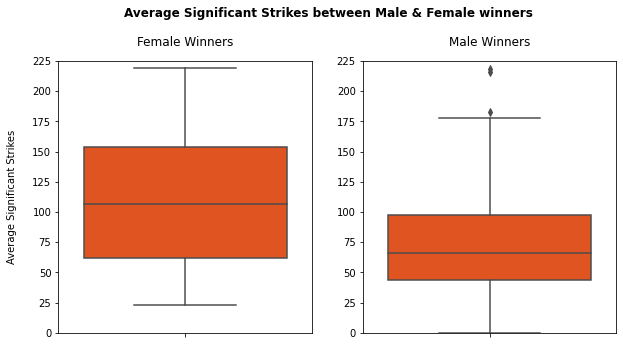

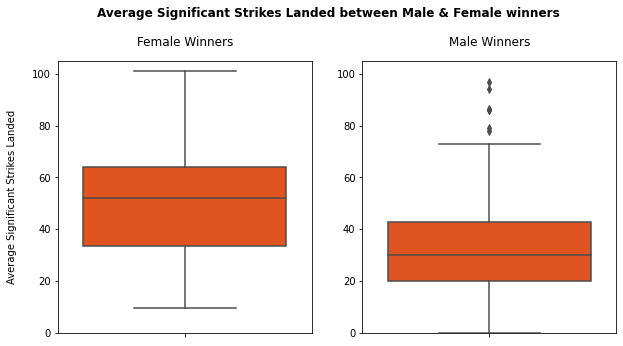

In [ ]:
#Compare Significant Strike Attack/Landed
plt.figure(figsize = (10,5))
ax1 = plt.subplot(121)
sns.boxplot(data=f_winners_att, y= 'avg_SIG_STR_att', color = 'orangered')
ax1.set_ylim([0, 225])
plt.ylabel('Average Significant Strikes', labelpad=15)
plt.title("Female Winners", pad=15)

ax2 = plt.subplot(122)
sns.boxplot(data=m_winners_att, y= 'avg_SIG_STR_att', color = 'orangered')
plt.title("Male Winners", pad=15)
ax2.set_ylim([0, 225])
plt.ylabel("")
plt.suptitle('Average Significant Strikes between Male & Female winners', weight='bold', y= 1.03)
plt.show()

print("\n")

plt.figure(figsize = (10,5))
ax3 = plt.subplot(121)
sns.boxplot(data=f_winners_landed, y= 'avg_SIG_STR_landed', color = 'orangered')
ax3.set_ylim([0, 105])
plt.ylabel('Average Significant Strikes Landed', labelpad=15)
plt.title("Female Winners", pad=15)

ax4 = plt.subplot(122)
sns.boxplot(data=m_winners_landed, y= 'avg_SIG_STR_landed', color = 'orangered')
plt.title("Male Winners", pad=15)
ax4.set_ylim([0, 105])
plt.ylabel("")
plt.suptitle('Average Significant Strikes Landed between Male & Female winners', weight='bold', y= 1.03)
plt.show()

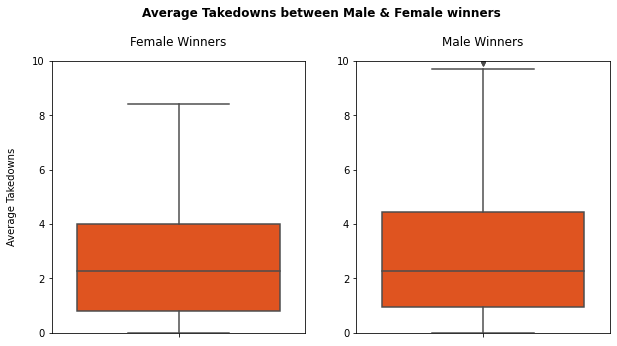

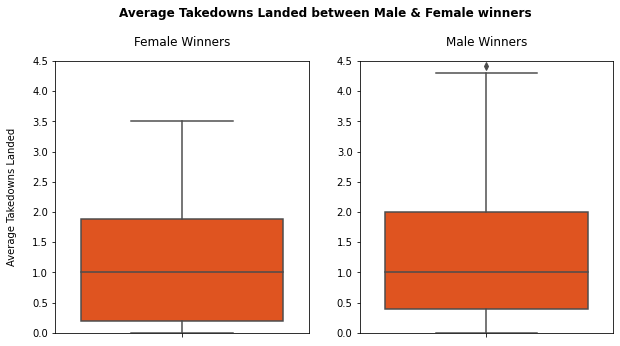

In [ ]:
#Compare Takedown Attack/Landed
plt.figure(figsize = (10,5))
ax1 = plt.subplot(121)
sns.boxplot(data=f_winners_att, y= 'avg_TD_att', color = 'orangered')
ax1.set_ylim([0, 10])
plt.ylabel('Average Takedowns', labelpad=15)
plt.title("Female Winners", pad=15)

ax2 = plt.subplot(122)
sns.boxplot(data=m_winners_att, y= 'avg_TD_att', color = 'orangered')
plt.title("Male Winners", pad=15)
ax2.set_ylim([0, 10])
plt.ylabel("")
plt.suptitle('Average Takedowns between Male & Female winners', weight='bold', y= 1.03)
plt.show()

print("\n")

plt.figure(figsize = (10,5))
ax3 = plt.subplot(121)
sns.boxplot(data=f_winners_landed, y= 'avg_TD_landed', color = 'orangered')
ax3.set_ylim([0, 4.5])
plt.ylabel('Average Takedowns Landed', labelpad=15)
plt.title("Female Winners", pad=15)

ax4 = plt.subplot(122)
sns.boxplot(data=m_winners_landed, y= 'avg_TD_landed', color = 'orangered')
plt.title("Male Winners", pad=15)
ax4.set_ylim([0, 4.5])
plt.ylabel("")
plt.suptitle('Average Takedowns Landed between Male & Female winners', weight='bold', y= 1.03)
plt.show()

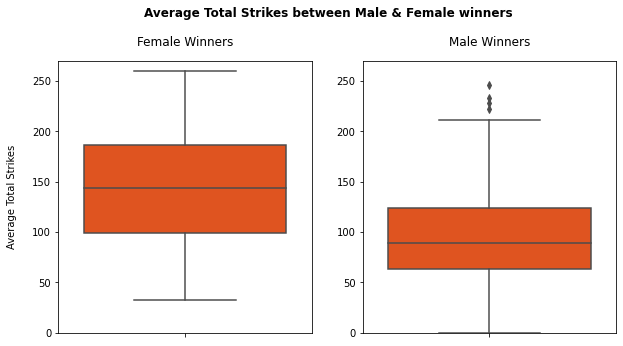

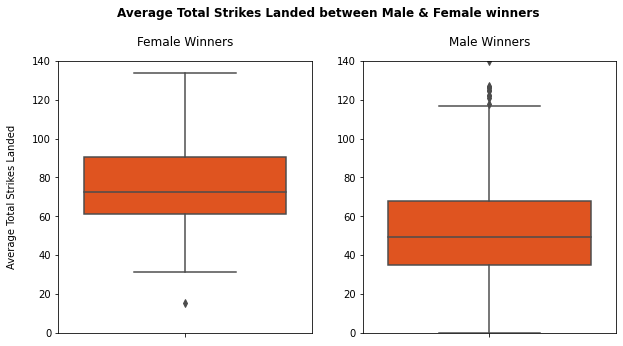

In [ ]:
#Compare Total Strike Attack/Landed
plt.figure(figsize = (10,5))
ax1 = plt.subplot(121)
sns.boxplot(data=f_winners_att, y= 'avg_TOTAL_STR_att', color = 'orangered')
ax1.set_ylim([0, 270])
plt.ylabel('Average Total Strikes', labelpad=15)
plt.title("Female Winners", pad=15)

ax2 = plt.subplot(122)
sns.boxplot(data=m_winners_att, y= 'avg_TOTAL_STR_att', color = 'orangered')
plt.title("Male Winners", pad=15)
ax2.set_ylim([0, 270])
plt.ylabel("")
plt.suptitle('Average Total Strikes between Male & Female winners', weight='bold', y= 1.03)
plt.show()

print("\n")

plt.figure(figsize = (10,5))
ax3 = plt.subplot(121)
sns.boxplot(data=f_winners_landed, y= 'avg_TOTAL_STR_landed', color = 'orangered')
ax3.set_ylim([0, 140])
plt.ylabel('Average Total Strikes Landed', labelpad=15)
plt.title("Female Winners", pad=15)

ax4 = plt.subplot(122)
sns.boxplot(data=m_winners_landed, y= 'avg_TOTAL_STR_landed', color ='orangered')
plt.title("Male Winners", pad=15)
ax4.set_ylim([0, 140])
plt.ylabel("")
plt.suptitle('Average Total Strikes Landed between Male & Female winners', weight='bold', y= 1.03)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Attack Style Distribution by Male Winners')

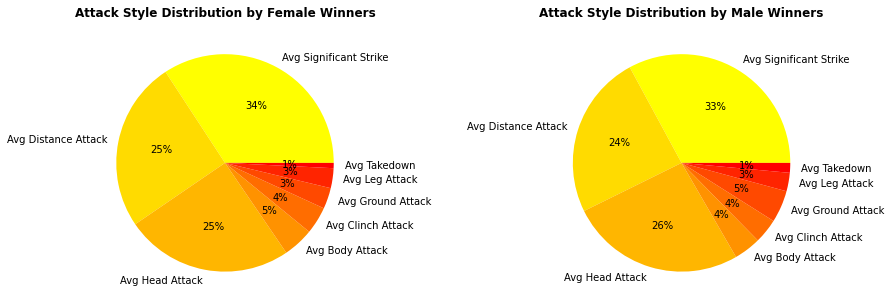

In [ ]:
#Q2 - COMPARE ATTACK STYLE BETWEEN FEMALE & MALE FIGHTERS
#Filter Attack Style Distibution by Gender
f_winners_att_avg = f_winners_att.mean().sort_values(ascending = False).drop(["avg_TOTAL_STR_att","avg_TOTAL_STatt","avg_SIG_STatt"]).reset_index().rename(columns={'index':'attack_style',0:'female_attack_style'})
m_winners_att_avg = m_winners_att.mean().drop(["avg_TOTAL_STR_att","avg_TOTAL_STatt","avg_SIG_STatt"]).reset_index().rename(columns={0:'male_attack_style'})
attack_style = pd.merge(f_winners_att_avg, m_winners_att_avg,  how='left', left_on='attack_style', right_on = 'index').drop(columns =['index']).round(2)

#Plot data:
plt.figure(figsize = (15,5))

plt.subplot(121)
labels = ['Avg Significant Strike','Avg Distance Attack','Avg Head Attack','Avg Body Attack','Avg Clinch Attack','Avg Ground Attack','Avg Leg Attack','Avg Takedown']
attack_style['female_attack_style'].plot(kind = "pie", labels=labels, autopct='%1.0f%%',cmap ="autumn_r")
plt.ylabel("")
plt.title('Attack Style Distribution by Female Winners', weight = "bold", pad = 10)

plt.subplot(122)
attack_style['male_attack_style'].plot(kind = "pie", labels=labels, autopct='%1.0f%%',cmap ="autumn_r")
plt.ylabel("")
plt.title('Attack Style Distribution by Male Winners', weight = "bold", pad = 10)


Text(0.5, 0, 'Year')

<Figure size 5040x1080 with 0 Axes>

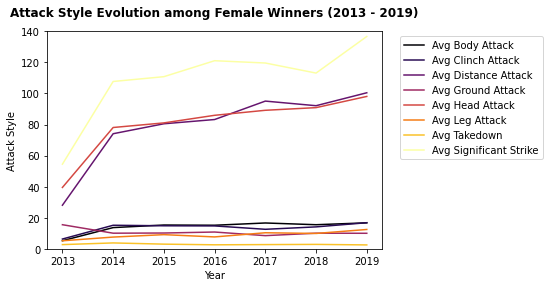

<Figure size 5040x1080 with 0 Axes>

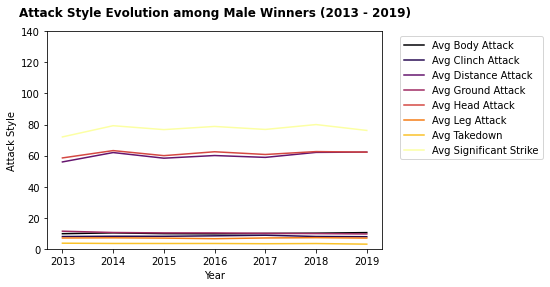

In [ ]:
#EVALUATE ATTACK STYLES BETWEEN FEMALE WINNERS:
#Get full Attack table
att_table_tmp2 = pd.concat([fighter_name,att_tmp], axis=1)
att_table_full = pd.merge(att_table_tmp2, matches[["R_fighter","date"]], left_on="fighter", right_on = 'R_fighter', how="left").drop(columns=(['R_fighter',"avg_TOTAL_STR_att","avg_TOTAL_STatt","avg_SIG_STatt"]))
att_table_full['date'] = pd.to_datetime(att_table_full['date'])

#Segment Attack table by year
att_table_full['year'] = pd.DatetimeIndex(att_table_full['date']).year
att_table_full.insert(1, 'year', att_table_full.pop('year'))
att_table_full.drop(columns = ['date'], inplace = True)

#Get full Attach Table for Female Winners (2013 - 2019):
f_att_full = pd.merge(f_winners_tmp, att_table_full,  how='left', left_on='fighter', right_on = 'fighter')
f_att_full = f_att_full.dropna(axis = 0, subset = ['year'])
f_att_full['year'] = f_att_full['year'].astype(int)
f_att_full = f_att_full.dropna(axis = 0, subset = ['year'])
f_att_full.drop(columns = ['fighter'], inplace = True)
f_att_full = f_att_full.groupby(['year']).mean().round(2).reset_index()

#Get full Attach Table for Male Winners (2013 - 2019): Male competition started in 1993 but Female Competition only started since 2013
m_att_full = pd.merge(m_winners_tmp, att_table_full,  how='left', left_on='fighter', right_on = 'fighter')
m_att_full = m_att_full.dropna(axis = 0, subset = ['year'])
m_att_full['year'] = m_att_full['year'].astype(int)
m_att_full = m_att_full.dropna(axis = 0, subset = ['year'])
m_att_full.drop(columns = ['fighter'], inplace = True)
m_att_full = m_att_full[m_att_full['year'] > 2012]
m_att_full = m_att_full.groupby(['year']).mean().round(2).reset_index()

#Plot data - Female Winners' Attack style
plt.figure(figsize = (70,15))
f_att_full.plot(kind='line', x = 'year', cmap = 'inferno')
line_labels = ['Avg Body Attack','Avg Clinch Attack','Avg Distance Attack','Avg Ground Attack','Avg Head Attack','Avg Leg Attack','Avg Takedown','Avg Significant Strike']
plt.title("Attack Style Evolution among Female Winners (2013 - 2019)", weight='bold', pad=15)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", labels = line_labels)
plt.ylabel("Attack Style")
plt.ylim(0,140)
plt.xlabel("Year")

print("\n")

#Plot data - Male Winners' Attack style
plt.figure(figsize = (70,15))
m_att_full.plot(kind='line', x = 'year', cmap = 'inferno')
plt.title("Attack Style Evolution among Male Winners (2013 - 2019)", weight='bold', pad=15)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", labels = line_labels)
plt.ylabel("Attack Style")
plt.ylim(0,140)
plt.xlabel("Year")
